# Mean field correlation dynamics for noisy signal propagation

In [1]:
# imports
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from matplotlib.collections import LineCollection

# custom imports
# from src.simulation import *
from src.numpy_simulation import *
from src.utils import load_experiment
from src.viz import get_colours
from src.theory import fixed_point
from src.theory import c_map_slope
from src.theory import c_map
from src.theory import depth_scale

# plot settings
sns.set_context("paper")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'

## --- Correlation map: Theory vs simulation ---

In [ ]:
# Compute experimental data
experiments = [
    {"dist": "none", "noise": (None, None), "act":"relu", "init":"crit"}, 
    {"dist": "bern", "noise": ('prob_1', 0.6), "act":"relu", "init":"crit"}, 
    {"dist": "bern", "noise": ('prob_1', 0.8), "act":"relu", "init":"crit"},
    {"dist": "mult gauss", "noise": ('std', 0.25), "act":"relu", "init":"crit"}, 
    {"dist": "mult gauss", "noise": ('std', 2), "act":"relu", "init":"crit"}
]

# run experiments
for i, experiment in enumerate(experiments):
    dist = experiment['dist']
    noise = experiment['noise']
    act = experiment['act']
    init = experiment['init']
    
    # run simulations for scenario
    noisy_signal_prop_simulations(dist, noise, act, init, seed=i)

### Iterative correlation map and correlation dynamics

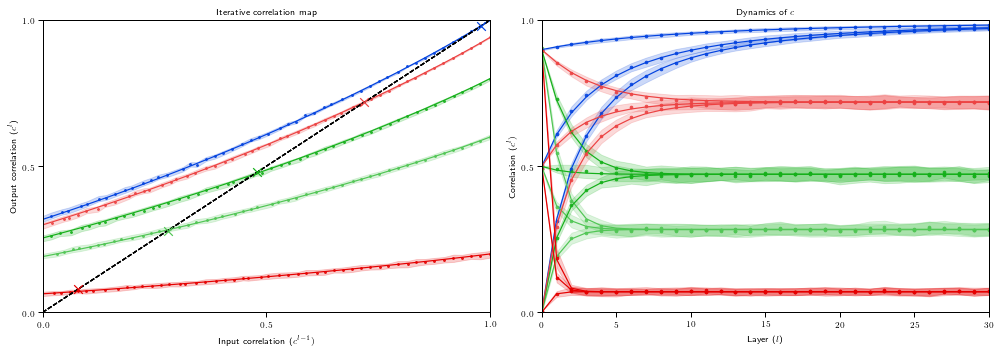

In [2]:
tests = [{
        "distributions": [{"dist": "none"}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.6}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "bern", "prob_1": 0.8}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 0.25}],
        "activations": ["relu"],
        "inits": ["crit"]
    }, {
        "distributions": [{"dist": "mult gauss", "std": 2}],
        "activations": ["relu"],
        "inits": ["crit"]
    }]


fig = plt.figure(figsize=(14, 5))
pal = get_colours(10, 7)
gs = plt.GridSpec(1, 2)
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

test_data = []
for i, test in enumerate(tests):
    test_data.append(load_experiment(test, 
                                      ["multi_layer_cmap_sim", "cmap", "ctrajs", "chi1", "cmap_sim"], "results"))

for test, attr in zip(test_data, tests):
    for dist in attr["distributions"]:
        if dist['dist'] == "none":
            col_i = 0
            shade_i = 6
        elif dist['dist'] == "bern":
            col_i = 1

            if float(dist['prob_1']) < 0.7:
                shade_i = 4
            else:
                shade_i = 6

        elif "gauss" in dist['dist']:
            col_i = 3

            if float(dist['std']) < 0.5:
                shade_i = 4
            else:
                shade_i = 6

        for act in attr["activations"]:
            for init in attr["inits"]:
                correlations = test[dist['dist']][act][init]['multi_layer_cmap_sim']
                cmap_data = test[dist['dist']][act][init]['cmap']
                cmaps = cmap_data["cmaps"]
                cstars = cmap_data["cstars"]
                ctrajs = test[dist['dist']][act][init]['ctrajs']
                cmap_sim_data = test[dist['dist']][act][init]['cmap_sim']
                cmap_sim_input = cmap_sim_data["input_correlations"]
                cmap_sim_output = cmap_sim_data["output_correlations"]

                num_trials = cmap_sim_input.shape[0]
                num_networks = cmap_sim_output.shape[0] // num_trials
                
                # create label
                label = ""

                try:
                    label = "$\sigma_\epsilon = $ " + str(dist['std'])
                except:
                    try:
                        label ="$p = $ " + str(dist['prob_1'])
                    except:
                        pass
                    # except:
                    #     label = dist_name

                ############################################################
                # left
                ############################################################
                crange = np.linspace(0, 1.0, 51)

                # Theory
                ax1.plot(crange, cmaps[0, 0], c=pal[col_i][shade_i], label=label)

                # Simulation
                mu_x = cmap_sim_input.mean(axis=0)
                mu_y = cmap_sim_output.mean(axis=0).mean(axis=0)
                std_y = cmap_sim_output.mean(axis=1).std(axis=0)

                ax1.scatter(mu_x, mu_y, marker="o", s=4, alpha=0.9, color=pal[col_i][shade_i])
                ax1.fill_between(mu_x, mu_y - std_y, mu_y + std_y, alpha=0.2, label='_nolegend_', color=pal[col_i][shade_i])

                # Add unity line
                ax1.plot((0, 1), (0, 1), '--', color='k', zorder=900)
                ax1.set_xlim(0, 1)
                ax1.set_ylim(0, 1)
                # ax3.axis('tight')

                ax1.scatter(cstars[0, 0], cstars[0, 0], s=75, marker= 'x', c=pal[col_i][shade_i], zorder=999, alpha=1.0, clip_on=False)

                ax1.set_title(r'Iterative correlation map')

                ############################################################
                # right - dynamics of convergence
                ############################################################
                # Theory
                for j in range(correlations.shape[0]):
                    ax2.plot(ctrajs[0, 0, j, :].T, c=pal[col_i][shade_i])


                # Simulations
                x_axis = np.arange(0, correlations.shape[-1])

                means = correlations.mean(axis=-2).mean(axis=-2)
                std = correlations.mean(axis=-2).std(axis=-2)

                for i in np.arange(means.shape[0]):
                    ax2.scatter(np.arange(means[i].shape[0]), means[i], marker='o', s=8, alpha=0.9, color=pal[col_i][shade_i])
                    ax2.fill_between(x_axis, means[i] - std[i], means[i] + std[i], alpha=0.2, label='_nolegend_', color=pal[col_i][shade_i])

ax1.set_xticks([0, 0.5, 1.0])
ax1.set_yticks([0, 0.5, 1.0])
ax1.set_xlabel('Input correlation ($c^{l-1})$')
ax1.set_ylabel('Output correlation ($c^{l}$)')

ax2.set_xlabel('Layer ($l$)')
ax2.set_ylabel('Correlation ($c^{l})$')
ax2.set_title('Dynamics of $c$')
ax2.set_yticks([0, 0.5, 1])
ax2.set_ylim(0, 1)
ax2.set_xlim(0, correlations.shape[-1] - 1)
# plt.show()
plt.gcf().tight_layout()
plt.savefig("correlation.pdf")

## --- Slope at correlation fixed point ---

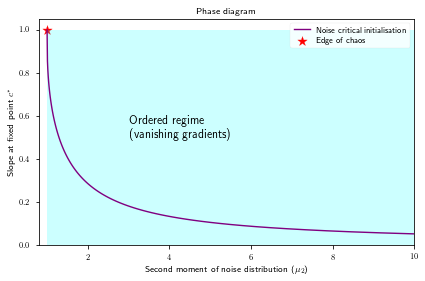

In [2]:
rates = np.linspace(0.1, 1, 100)
mu2s = 1/rates
fps = []
fp_slopes = []
for p in rates:
    mu2 = 1/p
    fpoint = fixed_point(c_map, p, p*2, mu2)
    fps.append(fpoint)

    slope = c_map_slope(fpoint, p*2)
    fp_slopes.append(slope)

plt.plot(mu2s, fp_slopes, c='purple', label="Noise critical initialisation")
plt.xlabel("Second moment of noise distribution ($\mu_2$)")
plt.ylabel("Slope at fixed point $c^*$")
plt.scatter(1, 1, c="red", marker='*', label='Edge of chaos', s=100)
plt.fill_between(mu2s, 0, 1, facecolor='cyan', alpha=0.2)
plt.text(3, 0.5, 'Ordered regime \n (vanishing gradients)', fontsize=12)
plt.legend()
plt.xlim(0.8, 10)
plt.ylim(0, 1.05)
plt.title('Phase diagram')
plt.gcf().tight_layout()
plt.show()